In [148]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special
import statsmodels.tools.numdiff as smnd # to compute the Hessian matrix

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

In [92]:
def y_ratio(e_ai, ei_ea):
    '''
    Computes the ratio of saturation to leakiness as defined by Daber and
    Lewis.
    Parameters
    ----------
    e_ai : array-like.
        Energy difference between the active and inactive conformation of 
        the repressor
    ei_ea : array-like/
        Originally the ratio Ka/Ki transformed into binding energies to work
        in log scale.
    '''
    return (1 + np.exp(-e_ai)) / (1 + np.exp(-e_ai) * np.exp(-2 * ei_ea))

In [93]:
def log_post(param, saturation, leakiness):
    '''
    Computes the log posterior of the two parameters e_ai and ei_ea assuming
    a Gaussian likelihood and uniform priors for both parameters given the 
    experimentally determined values of leakiness and saturation.
    Parameters
    ----------
    param : array-like.
        Array containing both parameters:
        param[0] = e_ai
        param[1] = ei_ea
    saturation, leakiness: array-like.
        Experimental values of the saturation and leakiness in fold-change.
    '''
    # Unpack parameters
    e_ai = param[0]
    ei_ea = param[1]
    
    # Compute the quantity used by Daber and Lewis to fit the parameters
    y_saturation = 1 / saturation - 1
    y_leakiness = 1 / leakiness - 1
    y_ratio_exp = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry = y_ratio(e_ai, ei_ea)
    
    # return the log posterior
    return -np.size(saturation) / 2 * \
           np.log(np.sum((y_ratio_exp - y_ratio_thry)**2))

## Testing the function with real data

In [125]:
datadir = '../../data/'
# read the list of data-sets to ignore
df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


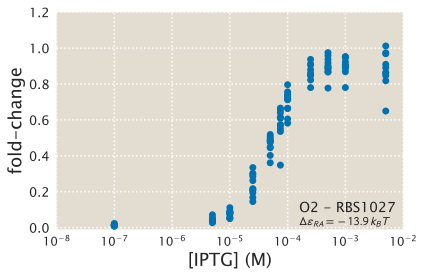

In [149]:
rbs = df[(df.rbs=='RBS1027') & (df.binding_energy==-13.9)]

fig, ax = plt.subplots(1, 1)

ax.plot(rbs.IPTG_uM / 1E6,
         rbs.fold_change_A, 'o',
         alpha=0.7)
ax.set_xscale('log')
ax.set_xlabel('[IPTG] (M)')
ax.set_ylabel('fold-change')
ax.set_xlim([1E-8, 1E-2])
ax.set_ylim([-0.01, 1.2])
# Add operator and binding energy labels.
ax.text(0.7, 0.08, r'{0}'.format('O2 - RBS1027'), transform=ax.transAxes, 
        fontsize=14)
ax.text(0.7, 0.02,
        r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %-13.9,
        transform=ax.transAxes, fontsize=12)

plt.tight_layout()

In [159]:
rbs.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
12,20160804,mrazomej,O2,-13.9,RBS1027,130,0.1,3666.908863,148.489234,0.008699
20,20160804,mrazomej,O2,-13.9,RBS1027,130,5.0,4240.010601,800.582704,0.045769
28,20160804,mrazomej,O2,-13.9,RBS1027,130,10.0,5366.244059,1951.434974,0.111151
36,20160804,mrazomej,O2,-13.9,RBS1027,130,25.0,9264.452797,5909.675420,0.334437


In [170]:
saturation = []
leakiness = []
rbs_group = rbs.groupby(['date', 'username'])
for group, data in rbs_group:
    if data.IPTG_uM.max() == 5000.0:
        saturation.append(data[data.IPTG_uM == data.IPTG_uM.max()].\
                          fold_change_A.values[0])
        leakiness.append(data[data.IPTG_uM == data.IPTG_uM.min()].\
                         fold_change_A.values[0])

saturation = np.array(saturation)
leakiness = np.array(leakiness)

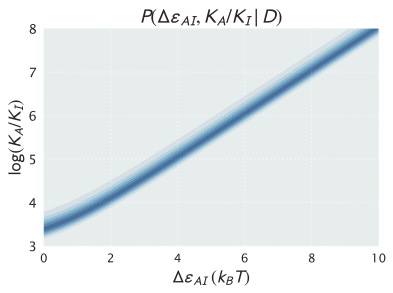

In [195]:
# Parameter values to plot
e_ai = np.linspace(0, 10, 150)
ei_ea = np.linspace(-8, -3, 150)

# make a grid to plot
eai_grid, ei_ea_grid = np.meshgrid(e_ai, ei_ea)

# compute the log posterior
log_posterior = np.empty_like(eai_grid)
for i in range(len(e_ai)):
    for j in range(len(ei_ea)):
        log_posterior[i, j] = log_post([eai_grid[i, j], ei_ea_grid[i, j]],\
                                       saturation, leakiness)

# Get things to scale better
log_posterior -= log_posterior.max()

# # plot the results
plt.figure()
plt.contourf(eai_grid, (-ei_ea_grid), np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\Delta\varepsilon_{AI}\; (k_BT)$')
# plt.ylabel(r'$\Delta\varepsilon_I - \Delta\varepsilon_A$')
plt.ylabel(r'$\log (K_A / K_I)$')
plt.title('$P(\Delta\epsilon_{AI}, K_A/K_I \mid D)$')